In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torchvision.models as models

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2

from functions import *
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import recall_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

Device used: cpu


In [2]:
train_size = 0.7
test_size = 1 - train_size
batch_size = 16

In [3]:
from customdataset import *
from augmentation import *

train_per = 0.6 # 60% of the data is used for training
val_per = 0.2 # 20% of the data is used for validation
test_per = 0.2 # 20% of the data is used for testing

batch_size = 64

X, Y, num_classes = import_data()

print(f'Number of classes: {num_classes}')
print(f'Number of images: {len(X)}')
print("")

X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y, train_per=train_per, val_per=val_per, test_per=test_per)

print(f'Number of training images: {len(X_train)}')
print(f'Number of validation images: {len(X_val)}')
print(f'Number of testing images: {len(X_test)}')
print("")

dataset_train = MyDataset(X_train, Y_train, augment=True)
dataset_val = MyDataset(X_val, Y_val, augment=False)
dataset_test = MyDataset(X_test, Y_test, augment=False)

print(f'Number of training images: {len(dataset_train)}')
print(f'Number of validation images: {len(dataset_val)}')
print(f'Number of testing images: {len(dataset_test)}')
print("")

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of testing batches: {len(test_loader)}')
print("")

Number of classes: 4
Number of images: 6400

Number of training images: 3840
Number of validation images: 1280
Number of testing images: 1280

Number of training images: 3840
Number of validation images: 1280
Number of testing images: 1280

Number of training batches: 60
Number of validation batches: 20
Number of testing batches: 20



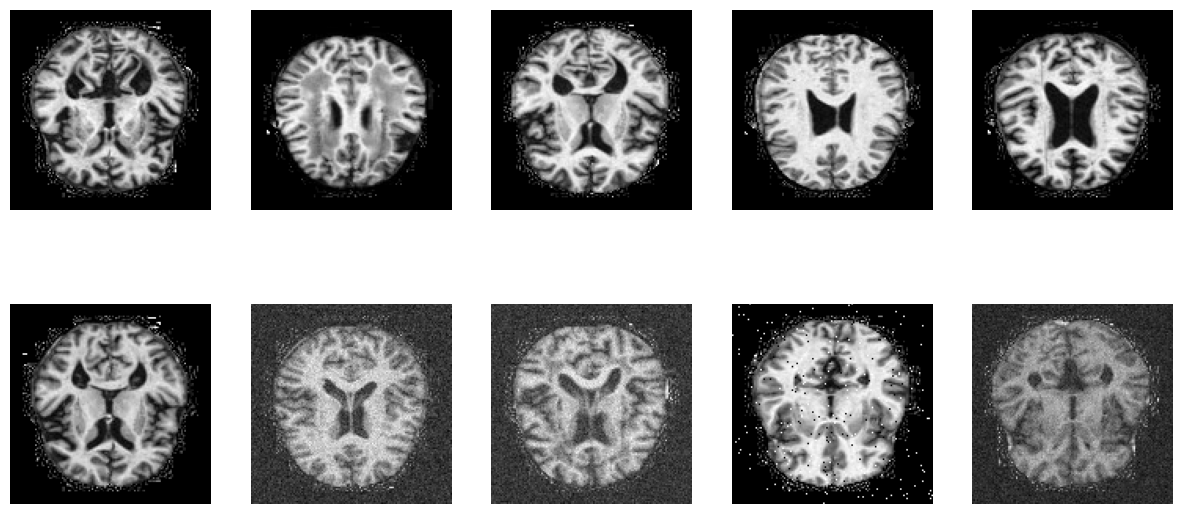

In [4]:
data_loader = train_loader

def dataloader_to_numpy(dataloader):
    images = []
    labels = []
    
    for batch in dataloader:
        batch_images, batch_labels = batch
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    
    return np.concatenate(images), np.concatenate(labels)

# Convert DataLoader to NumPy array
X, Y = dataloader_to_numpy(data_loader)

# Display 10 images
plt.figure(figsize=(15, 7))
num_images_to_display = 10
for i in range(min(num_images_to_display, len(X))):
    image = X[i].squeeze()  # Squeeze to remove the channel dimension for grayscale
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')  # Specify the colormap for grayscale images
    plt.axis("off")

plt.show()

# ResNet 18

In [5]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes, evaluation_metrics):
        super(CustomResNet18, self).__init__()
        # resnet = models.resnet18(pretrained=True)
        resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')

        # Change number of input channels
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # Add a custom fully connected layer
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

        # Initialize history dict
        self.evaluation_metrics = evaluation_metrics
        self.history = {key: [] for key in evaluation_metrics.keys()}
        self.history_validation = {key: [] for key in evaluation_metrics.keys()}

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def evaluate(self, dataloader):
        '''
        Returns the predicted labels in evaluation mode: y_pred, y_true
        '''
        state = False if self.training is False else True
        if state: self.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():  # Disable gradient computation during validation
            for i, (x_minibatch, y_true_batch) in enumerate(dataloader):
                y_pred_batch = F.softmax(self(x_minibatch), dim=1)
                y_true.extend(y_true_batch.tolist())
                y_pred.extend(y_pred_batch.tolist())
        if state: self.train()
        return y_pred, y_true

In [ ]:
criterion = nn.CrossEntropyLoss()

# Now define the metrics you want to monitor during training and save them in a dict (Important: All need to take y_pred, y_cls, y_true as input (This order!))
def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))
def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)
def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')
metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

# Define Model
model18 = CustomResNet18(num_classes=4, evaluation_metrics=metrics)

# Now define the loss (criterion), optimizer, lr_scheduler, 
early_stopper = EarlyStopper(model18, patience=7, min_delta=0)
optimizer = torch.optim.Adam(model18.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

train_network(model18, train_loader, criterion, optimizer, 70, scheduler, val_loader, device, early_stopper)

torch.save(model18, 'model_resnet_18.pth')

Device used for training: cpu
Epoch [1/70]  loss: 1.3044, acc: 0.4172, macro recall: 0.3062
Epoch [2/70]  loss: 1.2469, acc: 0.4688, macro recall: 0.2881
Epoch [3/70]  loss: 1.4196, acc: 0.1695, macro recall: 0.2695
Epoch [4/70]  loss: 1.1609, acc: 0.5672, macro recall: 0.3930
Epoch [5/70]  loss: 1.3377, acc: 0.2828, macro recall: 0.2847
Epoch [6/70]  loss: 1.1599, acc: 0.5406, macro recall: 0.3023
Epoch [7/70]  loss: 1.1575, acc: 0.5547, macro recall: 0.3070
Epoch [8/70]  loss: 1.1489, acc: 0.5500, macro recall: 0.3144
Epoch [9/70]  loss: 1.0676, acc: 0.6727, macro recall: 0.4282
Epoch [10/70]  loss: 1.0731, acc: 0.6687, macro recall: 0.5308
Epoch [11/70]  loss: 0.9331, acc: 0.8422, macro recall: 0.8048
Epoch [12/70]  loss: 0.9755, acc: 0.7742, macro recall: 0.5983
Epoch [13/70]  loss: 1.3538, acc: 0.3570, macro recall: 0.5810
Epoch [14/70]  loss: 0.9225, acc: 0.8258, macro recall: 0.6397
Epoch [15/70]  loss: 0.9135, acc: 0.8375, macro recall: 0.8856
Epoch [16/70]  loss: 0.8131, acc: 

In [ ]:
y_pred, y_true = model18.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_cls))
print(confusion_matrix(y_true, y_cls))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       640
           1       0.97      0.95      0.96       448
           2       0.94      0.94      0.94       179
           3       1.00      1.00      1.00        13

    accuracy                           0.96      1280
   macro avg       0.97      0.97      0.97      1280
weighted avg       0.96      0.96      0.96      1280

[[624  11   5   0]
 [ 15 427   6   0]
 [  7   3 169   0]
 [  0   0   0  13]]


In [7]:
num_params = sum(p.numel() for p in model18.parameters())
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 11172292


# ResNet 50

In [9]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes, evaluation_metrics):
        super(CustomResNet50, self).__init__()
        # resnet = models.resnet50(pretrained=True)
        resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        # Change number of input channels
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # Add a custom fully connected layer
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

        # Initialize history dict
        self.evaluation_metrics = evaluation_metrics
        self.history = {key: [] for key in evaluation_metrics.keys()}
        self.history_validation = {key: [] for key in evaluation_metrics.keys()}

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def evaluate(self, dataloader):
        '''
        Returns the predicted labels in evaluation mode: y_pred, y_true
        '''
        state = False if self.training is False else True
        if state: self.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():  # Disable gradient computation during validation
            for i, (x_minibatch, y_true_batch) in enumerate(dataloader):
                y_pred_batch = F.softmax(self(x_minibatch), dim=1)
                y_true.extend(y_true_batch.tolist())
                y_pred.extend(y_pred_batch.tolist())
        if state: self.train()
        return y_pred, y_true

In [12]:
criterion = nn.CrossEntropyLoss()

# Now define the metrics you want to monitor during training and save them in a dict (Important: All need to take y_pred, y_cls, y_true as input (This order!))
def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))
def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)
def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')
metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

# Define Model
model50 = CustomResNet50(num_classes=4, evaluation_metrics=metrics)

# Now define the loss (criterion), optimizer, lr_scheduler, 
early_stopper = EarlyStopper(model50, patience=7, min_delta=0)
optimizer = torch.optim.Adam(model50.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

train_network(model50, train_loader, criterion, optimizer, 70, scheduler, val_loader, device, early_stopper)

torch.save(model50, 'model_resnet_50.pth')

In [10]:
model50 = torch.load('model_resnet_50.pth')

In [14]:
y_pred, y_true = model50.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_cls))
print(confusion_matrix(y_true, y_cls))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       640
           1       0.94      0.96      0.95       448
           2       0.94      0.91      0.93       179
           3       1.00      1.00      1.00        13

    accuracy                           0.96      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.96      0.96      0.96      1280

[[622  15   3   0]
 [ 12 429   7   0]
 [  4  12 163   0]
 [  0   0   0  13]]


In [11]:
num_params = sum(p.numel() for p in model50.parameters())
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 23509956


# GoogleNet

In [13]:
class CustomGoogleNet(nn.Module):
    def __init__(self, num_classes, evaluation_metrics):
        super(CustomGoogleNet, self).__init__()
        # googlenet = models.googlenet(pretrained=True)
        googlenet = models.googlenet(weights='GoogLeNet_Weights.DEFAULT')

        # Change number of input channels
        googlenet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.features = nn.Sequential(*list(googlenet.children())[:-1])
        # Add a custom fully connected layer
        self.fc = nn.Linear(googlenet.fc.in_features, num_classes)

        # Initialize history dict
        self.evaluation_metrics = evaluation_metrics
        self.history = {key: [] for key in evaluation_metrics.keys()}
        self.history_validation = {key: [] for key in evaluation_metrics.keys()}

    def forward(self, x):
        # Ensure input has spatial dimensions (e.g., [batch_size, channels, height, width])
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def evaluate(self, dataloader):
        '''
        Returns the predicted labels in evaluation mode: y_pred, y_true
        '''
        state = False if self.training is False else True
        if state: self.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():  # Disable gradient computation during validation
            for i, (x_minibatch, y_true_batch) in enumerate(dataloader):
                y_pred_batch = F.softmax(self(x_minibatch), dim=1)
                y_true.extend(y_true_batch.tolist())
                y_pred.extend(y_pred_batch.tolist())
        if state: self.train()
        return y_pred, y_true

In [ ]:
criterion = nn.CrossEntropyLoss()

# Now define the metrics you want to monitor during training and save them in a dict (Important: All need to take y_pred, y_cls, y_true as input (This order!))
def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))
def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)
def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')
metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

# Define Model
model_googlenet = CustomGoogleNet(num_classes=4, evaluation_metrics=metrics)

# Now define the loss (criterion), optimizer, lr_scheduler, 
early_stopper = EarlyStopper(model_googlenet, patience=7, min_delta=0)
optimizer = torch.optim.Adam(model_googlenet.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

train_network(model_googlenet, train_loader, criterion, optimizer, 70, scheduler, val_loader, device, early_stopper)

torch.save(model_googlenet, 'model_googlenet.pth')

Device used for training: cpu
Epoch [1/70]  loss: 1.1790, acc: 0.5477, macro recall: 0.3060
Epoch [2/70]  loss: 1.2586, acc: 0.4641, macro recall: 0.2983
Epoch [3/70]  loss: 1.2705, acc: 0.4688, macro recall: 0.3059
Epoch [4/70]  loss: 1.3585, acc: 0.3531, macro recall: 0.2516
Epoch [5/70]  loss: 1.2374, acc: 0.5070, macro recall: 0.2554
Epoch [6/70]  loss: 1.2318, acc: 0.4922, macro recall: 0.4218
Epoch [7/70]  loss: 1.4450, acc: 0.1688, macro recall: 0.2660
Epoch [8/70]  loss: 1.1216, acc: 0.6125, macro recall: 0.4226
Epoch [9/70]  loss: 1.1895, acc: 0.5227, macro recall: 0.2702
Epoch [10/70]  loss: 1.1176, acc: 0.6156, macro recall: 0.3545
Epoch [11/70]  loss: 1.1583, acc: 0.5547, macro recall: 0.4951
Epoch [12/70]  loss: 1.0550, acc: 0.6781, macro recall: 0.4421
Epoch [13/70]  loss: 1.0764, acc: 0.6523, macro recall: 0.4132
Epoch [14/70]  loss: 1.5131, acc: 0.2023, macro recall: 0.2938
Epoch [15/70]  loss: 1.2275, acc: 0.5055, macro recall: 0.2541
Epoch [16/70]  loss: 0.8885, acc: 

In [14]:
model_googlenet = torch.load('model_googlenet.pth')

In [15]:
y_pred, y_true = model_googlenet.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_cls))
print(confusion_matrix(y_true, y_cls))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       640
           1       0.92      0.96      0.94       448
           2       0.96      0.89      0.92       179
           3       0.67      0.77      0.71        13

    accuracy                           0.95      1280
   macro avg       0.88      0.89      0.88      1280
weighted avg       0.95      0.95      0.95      1280

[[613  23   1   3]
 [ 15 429   4   0]
 [  4  14 159   2]
 [  1   1   1  10]]


In [16]:
num_params = sum(p.numel() for p in model_googlenet.parameters())
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 5597604
